In [74]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from matplotlib import rc
from matplotlib.font_manager import fontManager
from pathlib import Path
from fd_analysis.prepare import *
from collections import defaultdict

%matplotlib inline

In [75]:

font_path ='/usr/local/share/fonts/Virgil.ttf' 

# Register the font
fontManager.addfont(font_path)
font = {"family":"Virgil 3 YOFF"}

# Import data

In [110]:
paths_biomed = "../data/results_biomed_20240423/"

data_biomed, corrupt_biomed = filter_corrupt_files([Path(paths_biomed) / file for file in os.listdir(paths_biomed)])

print("Corrupt: ", corrupt_biomed)
len(data_biomed)


Corrupt:  []


1818

In [112]:
paths_pypi = "../data/results_pypi_20240423/"

data_pypi, corrupt_pypi = filter_corrupt_files([Path(paths_pypi) / file for file in os.listdir(paths_pypi)])

print("Corrupt: ", corrupt_pypi)
len(data_pypi)


Corrupt:  []


1160

In [113]:
data_biomed["markerGeneProfile.json"]

{'metadata': {'project_name': 'markerGeneProfile',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/PavlidisLab/markerGeneProfile.git',
  'creation_timestamp': '2024-04-23T15:56:58.527634'},
 'code_dirs': None,
 'deps_file': [],
 'imports': []}

# Code structure

In [114]:
codedirs = defaultdict(dict)
for k, d in data_biomed.items():
    project_name = d["metadata"]["project_name"]
    if d["code_dirs"] and d["imports"]:
        code_dirs = extract_code_directories(d["code_dirs"], project_name)
        codedirs[project_name] = code_dirs

df_codedirs_biomed = pd.DataFrame.from_dict(codedirs, orient="index")

In [115]:
codedirs = defaultdict(dict)
for k, d in data_pypi.items():
    project_name = d["metadata"]["project_name"]
    if d["code_dirs"] and d["imports"]:
        code_dirs = extract_code_directories(d["code_dirs"], project_name)
        codedirs[project_name] = code_dirs

df_codedirs_pypi = pd.DataFrame.from_dict(codedirs, orient="index")


In [116]:
python_projects_biomed = get_python_projects(data_biomed)
python_projects_pypi = get_python_projects(data_pypi)

In [117]:
len(python_projects_biomed), len(python_projects_pypi)

(1260, 1118)

In [118]:
df_codedirs_biomed.head(), df_codedirs_pypi.head()

(           PROJECT_NAME       test          .       doc/paper_figures        \
                      py ipynb   py ipynb   py ipynb                py ipynb   
 darkflow            1.0   0.0  1.0   0.0  1.0   0.0               NaN   NaN   
 encode2bag          4.0   0.0  2.0   0.0  1.0   0.0               NaN   NaN   
 osmosis             1.0   0.0  NaN   NaN  1.0   0.0               4.0  17.0   
 brian2genn          5.0   0.0  NaN   NaN  NaN   NaN               NaN   NaN   
 yeadon              6.0   0.0  NaN   NaN  1.0   0.0               NaN   NaN   
 
            doc/sphinxext        ... layer_runs2/n_message_2        \
                       py ipynb  ...                      py ipynb   
 darkflow             NaN   NaN  ...                     NaN   NaN   
 encode2bag           NaN   NaN  ...                     NaN   NaN   
 osmosis              8.0   0.0  ...                     NaN   NaN   
 brian2genn           NaN   NaN  ...                     NaN   NaN   
 yeadon           

In [119]:
codedirs_py_biomed = df_codedirs_biomed.xs("py", level=1, axis=1)
codedirs_ipynb_biomed = df_codedirs_biomed.xs("ipynb", level=1, axis=1)
codedirs_sum_biomed = codedirs_py_biomed + codedirs_ipynb_biomed

codedirs_py_pypi = df_codedirs_pypi.xs("py", level=1, axis=1)
codedirs_ipynb_pypi = df_codedirs_pypi.xs("ipynb", level=1, axis=1)
codedirs_sum_pypi = codedirs_py_pypi + codedirs_ipynb_pypi


In [120]:
codedirs_sum_biomed

,PROJECT_NAME,test,.,doc/paper_figures,doc/sphinxext,bin,doc/demonstrations,doc,tests,biothings_client/utils,...,layer_runs2/n_message_6,layer_runs2/n_message_1,layer_runs2/n_message_7,layer_runs2/n_message_8,layer_runs2/n_message_9,layer_runs2/n_message_2,layer_runs2/n_message_4,layer_runs2/n_message_10,layer_runs2/n_message_3,20190909_figure4
darkflow,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,1.0,NaN,1.0,21.0,8.0,6.0,3.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,6.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
diffusion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nextmed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ReproPhylo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x2k_web,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
drop_cols_biomed = [
    col
    for col in codedirs_sum_biomed.columns
    if "test" in col.lower() or "example" in col.lower() or "sample" in col.lower()
]

drop_cols_pypi = [
    col
    for col in codedirs_sum_pypi.columns
    if "test" in col.lower() or "example" in col.lower() or "sample" in col.lower()
]

In [122]:
codedirs_sum_main_biomed = codedirs_sum_biomed.drop(columns = drop_cols_biomed).idxmax(axis=1)
codedirs_sum_main_pypi = codedirs_sum_pypi.drop(columns = drop_cols_pypi).idxmax(axis=1)


/tmp/ipykernel_688652/1777460513.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  codedirs_sum_main_biomed = codedirs_sum_biomed.drop(columns = drop_cols_biomed).idxmax(axis=1)
/tmp/ipykernel_688652/1777460513.py:2: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  codedirs_sum_main_pypi = codedirs_sum_pypi.drop(columns = drop_cols_pypi).idxmax(axis=1)


In [123]:
codedirs_sum_main_biomed, codedirs_sum_main_pypi

(darkflow                   PROJECT_NAME
 encode2bag                 PROJECT_NAME
 osmosis               doc/paper_figures
 brian2genn                      scripts
 yeadon                     PROJECT_NAME
                         ...            
 diffusion                           NaN
 nextmed               src visualization
 ReproPhylo         Tutorial_files/Basic
 x2k_web       src/main/webapp/notebooks
 deep-rules               content/images
 Length: 1260, dtype: object,
 jupyter_ydoc                                                       PROJECT_NAME
 jira                                                               PROJECT_NAME
 rasterio                                                           PROJECT_NAME
 pygit2                                                             PROJECT_NAME
 Box                                                                PROJECT_NAME
                                                     ...                        
 ApplicationInsights-Python    az

In [124]:
same_name_projects_biomed = set([k for k, v in codedirs_sum_main_biomed.items() if v == "PROJECT_NAME"])
src_projects_biomed = set([k for k, v in codedirs_sum_main_biomed.items() if not v != v and v.startswith("src")])
root_dir_projects_biomed = set([k for k, v in codedirs_sum_main_biomed.items() if v == "."])
rest_projects_biomed = python_projects_biomed - same_name_projects_biomed - src_projects_biomed - root_dir_projects_biomed

same_name_projects_pypi = set([k for k, v in codedirs_sum_main_pypi.items() if v == "PROJECT_NAME"])
src_projects_pypi = set([k for k, v in codedirs_sum_main_pypi.items() if not v != v and v.startswith("src")])
root_dir_projects_pypi = set([k for k, v in codedirs_sum_main_pypi.items() if v == "."])
rest_projects_pypi = python_projects_pypi - same_name_projects_pypi - src_projects_pypi - root_dir_projects_pypi


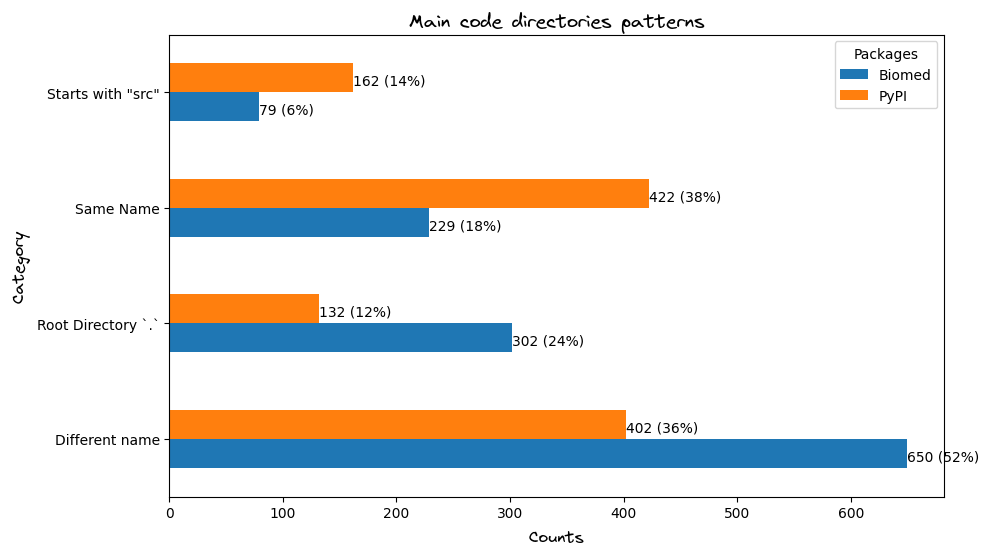

In [125]:
plot_data_biomed = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Counts": [
            len(same_name_projects_biomed),
            len(src_projects_biomed),
            len(rest_projects_biomed),
            len(root_dir_projects_biomed),
        ],
        "Percentage": [0.25,0.25,0.25,0.25],
    }
)
plot_data_pypi = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Counts": [
            len(same_name_projects_pypi),
            len(src_projects_pypi),
            len(rest_projects_pypi),
            len(root_dir_projects_pypi),
        ],
        "Percentage": [0.25,0.25,0.25,0.25],
    }
)

plot_data_biomed["Group"] = "Biomed"
plot_data_pypi["Group"] = "PyPI"

plot_data = pd.concat([plot_data_biomed, plot_data_pypi])
grouped_data = plot_data.groupby(['Group', 'Category']).sum().reset_index()

# Create a pivot table for easier plotting
pivot_table = grouped_data.pivot(index='Category', columns='Group', values='Counts')

# Plotting
ax = pivot_table.plot(kind='barh')
plt.xlabel('Counts', fontname='Virgil 3 YOFF', fontsize=12)
plt.ylabel('Category', fontname='Virgil 3 YOFF', fontsize=12)
plt.title('Main code directories patterns', fontname='Virgil 3 YOFF', fontsize=14)
plt.legend(title='Packages')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if ax.patches.index(p) < 4:
        ax.annotate(f'{width} ({width/len(python_projects_biomed):.0%})', (x + width, y + height/4))
    else:
        ax.annotate(f'{width} ({width/len(python_projects_pypi):.0%})', (x + width, y + height/4))
plt.savefig("code_structure.png", dpi=600, bbox_inches="tight")
plt.show()

# Dependency declarations

In [126]:
depsfiles_biomed = get_depsfiles(data_biomed)
depsfiles_pypi = get_depsfiles(data_pypi)

732


1117


In [92]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format

In [127]:
python_projects_pypi - depsfiles_pypi.keys()

{'ResizeRight'}

In [128]:
data_pypi["ResizeRight.json"]

{'metadata': {'project_name': 'ResizeRight',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/assafshocher/ResizeRight.git',
  'creation_timestamp': '2024-04-23T12:00:19.788031'},
 'code_dirs': {'.': {'py': 2, 'ipynb': 0, 'total': 2}},
 'deps_file': [],
 'imports': [{'Regular': {'name': 'torch',
    'source': {'path': 'resize_right.py', 'lineno': 13}}},
  {'Regular': {'name': 'torch',
    'source': {'path': 'resize_right.py', 'lineno': 14}}},
  {'Regular': {'name': 'numpy',
    'source': {'path': 'resize_right.py', 'lineno': 22}}},
  {'Regular': {'name': 'torch',
    'source': {'path': 'interp_methods.py', 'lineno': 4}}},
  {'Regular': {'name': 'numpy',
    'source': {'path': 'interp_methods.py', 'lineno': 9}}}]}

In [129]:
dep_counts_biomed = np.array([len(depsfiles_biomed), len(python_projects_biomed) - len(depsfiles_biomed)])
dep_counts_pypi = np.array([len(depsfiles_pypi), len(python_projects_pypi) - len(depsfiles_pypi)])


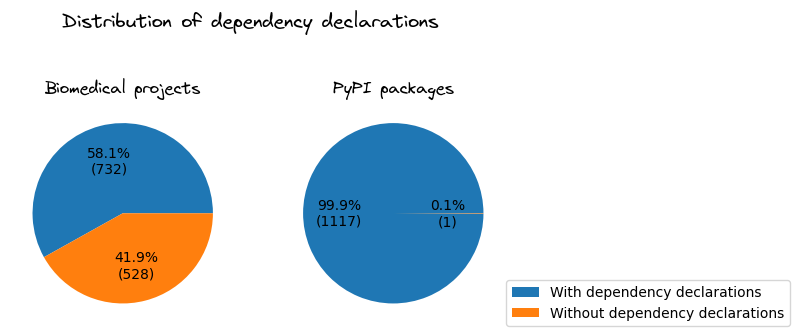

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle("Distribution of dependency declarations", fontname='Virgil 3 YOFF', fontsize=14)
ax1.pie(dep_counts_biomed, autopct=autopct_format(dep_counts_biomed))
ax1.set_title('Biomedical projects', fontname='Virgil 3 YOFF', fontsize=12)
ax2.pie(dep_counts_pypi, autopct=autopct_format(dep_counts_pypi))
ax2.set_title('PyPI packages', fontname='Virgil 3 YOFF', fontsize=12)
plt.legend(loc=(1, 0), labels = ["With dependency declarations", "Without dependency declarations"])
plt.subplots_adjust(top=1)
plt.savefig("distribution_deps_1.png", dpi=600, bbox_inches="tight")


In [139]:
project_req_txt = set()
project_pyproject_toml = set()
project_setup = set()

for project_name, deps in depsfiles_biomed.items():
    for dep in deps:
        if dep["parser_choice"] == "requirements.txt":
            project_req_txt.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"] == "pyproject.toml":
            project_pyproject_toml.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"].startswith("setup") and dep["deps_count"] > 0:
            project_setup.add(project_name)
            break

In [140]:
project_req_txt_pypi = set()
project_pyproject_toml_pypi = set()
project_setup_pypi = set()

for project_name, deps in depsfiles_pypi.items():
    for dep in deps:
        if dep["parser_choice"] == "requirements.txt":
            project_req_txt_pypi.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"] == "pyproject.toml":
            project_pyproject_toml_pypi.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"].startswith("setup") and dep["deps_count"] > 0:
            project_setup_pypi.add(project_name)
            break


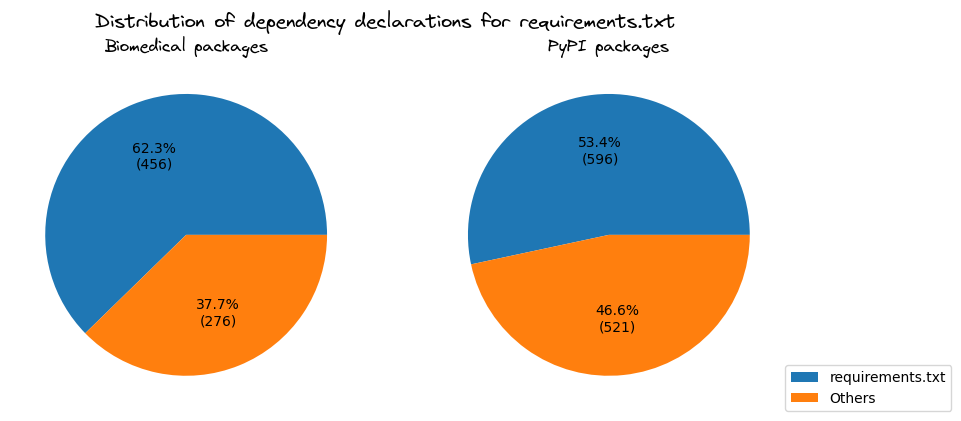

In [141]:
req_txt_counts = np.array([len(project_req_txt), len(depsfiles_biomed) - len(project_req_txt)])
req_txt_counts_pypi = np.array([len(project_req_txt_pypi), len(depsfiles_pypi) - len(project_req_txt_pypi)])

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle("Distribution of dependency declarations for requirements.txt", fontname='Virgil 3 YOFF', fontsize=14)
ax1.pie(req_txt_counts, autopct=autopct_format(req_txt_counts))
ax1.set_title("Biomedical packages", fontname='Virgil 3 YOFF', fontsize=12)
ax2.pie(req_txt_counts_pypi, autopct=autopct_format(req_txt_counts_pypi))
ax2.set_title('PyPI packages', fontname='Virgil 3 YOFF', fontsize=12)
plt.legend(loc=(1, 0), labels = ["requirements.txt", "Others"])
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.1.png", dpi=600, bbox_inches="tight")


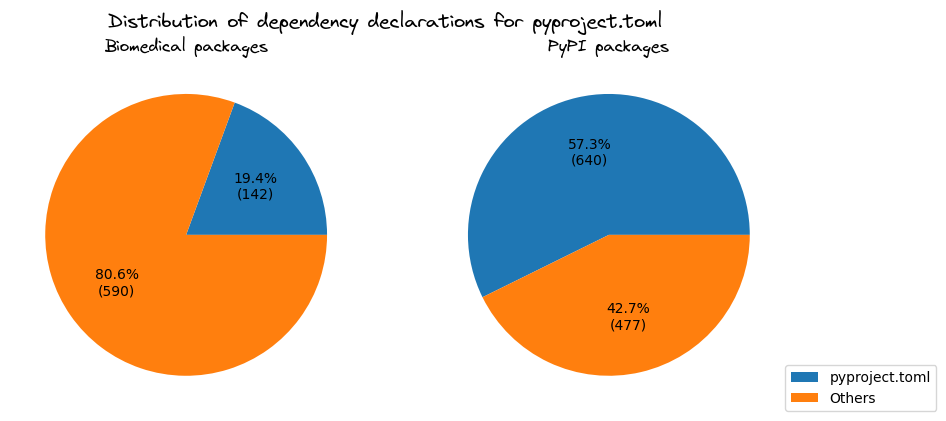

In [142]:
pyproject_toml_counts = np.array([len(project_pyproject_toml), len(depsfiles_biomed) - len(project_pyproject_toml)])
pyproject_toml_counts_pypi = np.array([len(project_pyproject_toml_pypi), len(depsfiles_pypi) - len(project_pyproject_toml_pypi)])

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle("Distribution of dependency declarations for pyproject.toml", fontname='Virgil 3 YOFF', fontsize=14)
ax1.pie(pyproject_toml_counts, autopct=autopct_format(pyproject_toml_counts))
ax1.set_title("Biomedical packages", fontname='Virgil 3 YOFF', fontsize=12)
ax2.pie(pyproject_toml_counts_pypi, autopct=autopct_format(pyproject_toml_counts_pypi))
ax2.set_title('PyPI packages', fontname='Virgil 3 YOFF', fontsize=12)
plt.legend(loc=(1, 0), labels = ["pyproject.toml", "Others"])
plt.subplots_adjust(top=1.1)
# plt.savefig("distribution_deps_2.2.png", dpi=600, bbox_inches="tight")

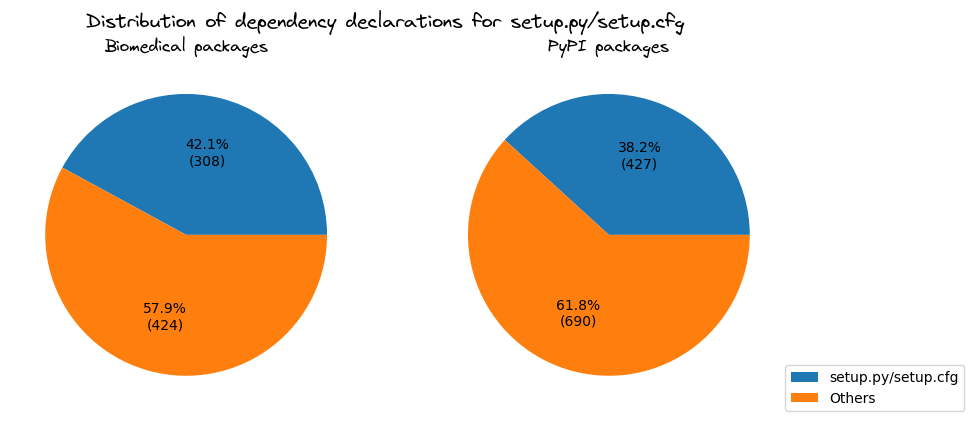

In [144]:
setup_counts = np.array([len(project_setup), len(depsfiles_biomed) - len(project_setup)])
setup_counts_pypi = np.array([len(project_setup_pypi), len(depsfiles_pypi) - len(project_setup_pypi)])

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle("Distribution of dependency declarations for setup.py/setup.cfg", fontname='Virgil 3 YOFF', fontsize=14)
ax1.pie(setup_counts, autopct=autopct_format(setup_counts))
ax1.set_title("Biomedical packages", fontname='Virgil 3 YOFF', fontsize=12)
ax2.pie(setup_counts_pypi, autopct=autopct_format(setup_counts_pypi))
ax2.set_title('PyPI packages', fontname='Virgil 3 YOFF', fontsize=12)
plt.legend(loc=(1, 0), labels = ["setup.py/setup.cfg", "Others"])
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.3.png", dpi=600, bbox_inches="tight")

In [145]:
project_req_only = project_req_txt - project_pyproject_toml - project_setup
project_toml_only = project_pyproject_toml - project_req_txt - project_setup
project_setup_only = project_setup - project_req_txt - project_pyproject_toml
project_req_toml = project_req_txt.intersection(
    project_pyproject_toml
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_setup = project_req_txt.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_toml_setup = project_pyproject_toml.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_toml_setup = project_req_txt.intersection(
    project_pyproject_toml
).intersection(project_setup)
project_no_deps = python_projects_biomed - depsfiles_biomed.keys()


In [146]:
project_req_only_pypi = project_req_txt_pypi - project_pyproject_toml_pypi - project_setup_pypi
project_toml_only_pypi = project_pyproject_toml_pypi - project_req_txt_pypi - project_setup_pypi
project_setup_only_pypi = project_setup_pypi - project_req_txt_pypi - project_pyproject_toml_pypi
project_req_toml_pypi = project_req_txt_pypi.intersection(
    project_pyproject_toml_pypi
) - project_req_txt_pypi.intersection(project_pyproject_toml_pypi).intersection(project_setup_pypi)
project_req_setup_pypi = project_req_txt_pypi.intersection(
    project_setup_pypi
) - project_req_txt_pypi.intersection(project_pyproject_toml_pypi).intersection(project_setup_pypi)
project_toml_setup_pypi = project_pyproject_toml_pypi.intersection(
    project_setup_pypi
) - project_req_txt_pypi.intersection(project_pyproject_toml_pypi).intersection(project_setup_pypi)
project_req_toml_setup_pypi = project_req_txt_pypi.intersection(
    project_pyproject_toml_pypi
).intersection(project_setup_pypi)
project_no_deps_pypi = python_projects_pypi - depsfiles_pypi.keys()


In [147]:
df_deps_count = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only),
            len(project_toml_only),
            len(project_setup_only),
            len(project_req_toml),
            len(project_req_setup),
            len(project_toml_setup),
            len(project_req_toml_setup),
            len(python_projects_biomed) - len(depsfiles_biomed)
        ],
    )
)


In [148]:
df_deps_count_pypi = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only_pypi),
            len(project_toml_only_pypi),
            len(project_setup_only_pypi),
            len(project_req_toml_pypi),
            len(project_req_setup_pypi),
            len(project_toml_setup_pypi),
            len(project_req_toml_setup_pypi),
            len(python_projects_pypi) - len(depsfiles_pypi)
        ],
    )
)


In [149]:
desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg"
]

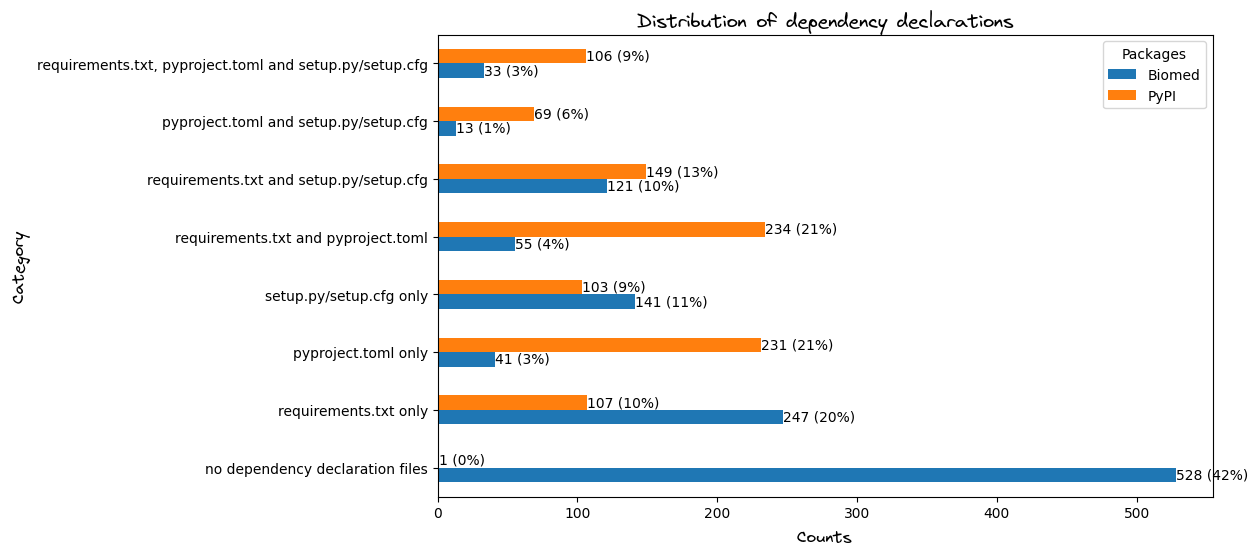

In [150]:
df_deps_count["Group"] = "Biomed"
df_deps_count_pypi["Group"] = "PyPI"
deps_count_combined = pd.concat([df_deps_count, df_deps_count_pypi])
grouped_data = deps_count_combined.groupby(['Group', 'type_']).sum().reset_index()

# Create a pivot table for easier plotting
pivot_table = grouped_data.pivot(index='type_', columns='Group', values='count').reindex(desired_order)

# Plotting
plt.rcParams["figure.figsize"] = [10,6]
ax = pivot_table.plot(kind='barh')

plt.xlabel('Counts', fontname='Virgil 3 YOFF', fontsize=12)
plt.ylabel('Category', fontname='Virgil 3 YOFF', fontsize=12)
plt.title('Distribution of dependency declarations', fontname='Virgil 3 YOFF', fontsize=14)
plt.legend(title='Packages')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if ax.patches.index(p) < 8:
        ax.annotate(f'{width} ({width/len(python_projects_biomed):.0%})', (x + width, y + height/4))
    else:
        ax.annotate(f'{width} ({width/len(python_projects_pypi):.0%})', (x + width, y + height/4))
plt.savefig("distribution_deps_3.png", dpi=600, bbox_inches="tight")
plt.show()


<Figure size 1000x600 with 0 Axes>

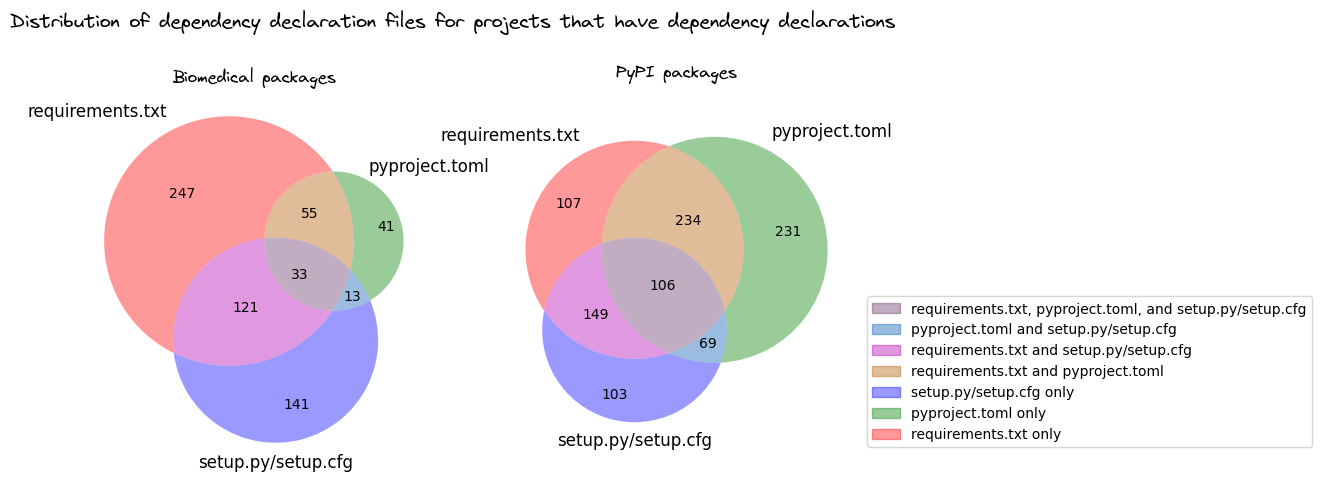

In [155]:
# Draw a venn diagram
plt.figure()
# ax = plt.gca()
fig, (ax1,ax2) = plt.subplots(1, 2)

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax1,
)

venn_parsers_pypi = venn3(
    [project_req_txt_pypi, project_pyproject_toml_pypi, project_setup_pypi],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax2,
)


# Define labels for all sets and intersections
# for a 3-circle diagram, the sequence is 100, 010, 110, 001, 101, 011, 111
legend_labels = [
    f"{set_1_name} only",
    f"{set_2_name} only",
    f"{set_1_name} and {set_2_name}",
    f"{set_3_name} only",
    f"{set_1_name} and {set_3_name}",
    f"{set_2_name} and {set_3_name}",
    f"{set_1_name}, {set_2_name}, and {set_3_name}",
]

legend_handles = [
    Patch(
        color=patch.get_facecolor(),
        label=legend_labels[venn_parsers.patches.index(patch)],
    )
    for patch in venn_parsers.patches
    if patch
]
order = [6, 5, 4, 2, 3, 1, 0]
plt.legend(handles=[legend_handles[idx] for idx in order], loc=(1.04, 0))

ax1.set_title("Biomedical packages", fontname='Virgil 3 YOFF', fontsize=12)
ax2.set_title('PyPI packages', fontname='Virgil 3 YOFF', fontsize=12, y=1.08)

plt.suptitle(
    "Distribution of dependency declaration files for projects that have dependency declarations", fontname='Virgil 3 YOFF', fontsize=14)
plt.subplots_adjust(top=0.95)

plt.savefig("distribution_deps_4.png", dpi=600, bbox_inches="tight")


# Correlation

In [156]:
conditions = [
    (codedirs_sum_main_biomed.index.isin(project_dep)) for project_dep in [project_req_only, project_toml_only, project_setup_only, project_req_toml, project_req_setup, project_toml_setup, project_req_toml_setup, project_no_deps]
]
# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]

codedirs_sum_main_biomed = pd.DataFrame(codedirs_sum_main_biomed)
codedirs_sum_main_biomed["deps"] = np.select(conditions, values)
codedirs_sum_main_biomed["deps"] = pd.Categorical(
    codedirs_sum_main_biomed["deps"], categories=desired_order, ordered=True
)

In [157]:
conditions_pypi = [
    (codedirs_sum_main_pypi.index.isin(project_dep)) for project_dep in [project_req_only_pypi, project_toml_only_pypi, project_setup_only_pypi, project_req_toml_pypi, project_req_setup_pypi, project_toml_setup_pypi, project_req_toml_setup_pypi, project_no_deps_pypi]
]
codedirs_sum_main_pypi = pd.DataFrame(codedirs_sum_main_pypi)
codedirs_sum_main_pypi["deps"] = np.select(conditions_pypi, values)
codedirs_sum_main_pypi["deps"] = pd.Categorical(
    codedirs_sum_main_pypi["deps"], categories=desired_order, ordered=True
)


In [158]:
codedirs_sum_main_biomed.head(), codedirs_sum_main_pypi.head()

(                            0                                     deps
 darkflow         PROJECT_NAME                    requirements.txt only
 encode2bag       PROJECT_NAME                  setup.py/setup.cfg only
 osmosis     doc/paper_figures                                      NaN
 brian2genn            scripts                      pyproject.toml only
 yeadon           PROJECT_NAME  requirements.txt and setup.py/setup.cfg,
                          0                                               deps
 jupyter_ydoc  PROJECT_NAME                                pyproject.toml only
 jira          PROJECT_NAME                                pyproject.toml only
 rasterio      PROJECT_NAME                requirements.txt and pyproject.toml
 pygit2        PROJECT_NAME  requirements.txt, pyproject.toml and setup.py/...
 Box           PROJECT_NAME            requirements.txt and setup.py/setup.cfg)

In [159]:
codedirs_sum_biomed.head()


,PROJECT_NAME,test,.,doc/paper_figures,doc/sphinxext,bin,doc/demonstrations,doc,tests,biothings_client/utils,...,layer_runs2/n_message_6,layer_runs2/n_message_1,layer_runs2/n_message_7,layer_runs2/n_message_8,layer_runs2/n_message_9,layer_runs2/n_message_2,layer_runs2/n_message_4,layer_runs2/n_message_10,layer_runs2/n_message_3,20190909_figure4
darkflow,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,1.0,NaN,1.0,21.0,8.0,6.0,3.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,6.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
codedirs_sum_main_biomed["count"] = [codedirs_sum_biomed.loc[idx][codedirs_sum_main_biomed[0].loc[idx]] if type(codedirs_sum_main_biomed[0].loc[idx]) == str else 0.0 for idx in codedirs_sum_biomed.index]

codedirs_sum_main_biomed[".py count"] = [codedirs_py_biomed.loc[idx][codedirs_sum_main_biomed[0].loc[idx]] if type(codedirs_sum_main_biomed[0].loc[idx]) == str else 0.0 for idx in codedirs_py_biomed.index]

codedirs_sum_main_biomed[".ipynb count"] = [codedirs_ipynb_biomed.loc[idx][codedirs_sum_main_biomed[0].loc[idx]] if type(codedirs_sum_main_biomed[0].loc[idx]) == str else 0.0 for idx in codedirs_ipynb_biomed.index]


In [162]:
codedirs_sum_main_pypi["count"] = [codedirs_sum_pypi.loc[idx][codedirs_sum_main_pypi[0].loc[idx]] if type(codedirs_sum_main_pypi[0].loc[idx]) == str else 0.0 for idx in codedirs_sum_pypi.index]

codedirs_sum_main_pypi[".py count"] = [codedirs_py_pypi.loc[idx][codedirs_sum_main_pypi[0].loc[idx]] if type(codedirs_sum_main_pypi[0].loc[idx]) == str else 0.0 for idx in codedirs_py_pypi.index]

codedirs_sum_main_pypi[".ipynb count"] = [codedirs_ipynb_pypi.loc[idx][codedirs_sum_main_pypi[0].loc[idx]] if type(codedirs_sum_main_pypi[0].loc[idx]) == str else 0.0 for idx in codedirs_ipynb_pypi.index]


In [163]:
codedirs_sum_main_biomed[".ipynb>=5"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 5, True, False
)

In [164]:
codedirs_sum_main_biomed[".ipynb>=10"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 10, True, False
)

In [165]:
codedirs_sum_main_biomed[".ipynb>=15"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 15, True, False
)

In [166]:
codedirs_sum_main_biomed[".ipynb>=20"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 20, True, False
)

In [167]:
codedirs_sum_main_pypi[".ipynb>=5"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 5, True, False
)

In [168]:
codedirs_sum_main_pypi[".ipynb>0"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] > 0, True, False
)

In [169]:
codedirs_sum_main_biomed.head()

,0,deps,count,.py count,.ipynb count,.ipynb>=5,.ipynb>=10,.ipynb>=15,.ipynb>=20
darkflow,PROJECT_NAME,requirements.txt only,1.0,1.0,0.0,False,False,False,False
encode2bag,PROJECT_NAME,setup.py/setup.cfg only,4.0,4.0,0.0,False,False,False,False
osmosis,doc/paper_figures,NaN,21.0,4.0,17.0,True,True,True,False
brian2genn,scripts,pyproject.toml only,6.0,6.0,0.0,False,False,False,False
yeadon,PROJECT_NAME,requirements.txt and setup.py/setup.cfg,6.0,6.0,0.0,False,False,False,False


Text(0, 0.5, 'Python code count')

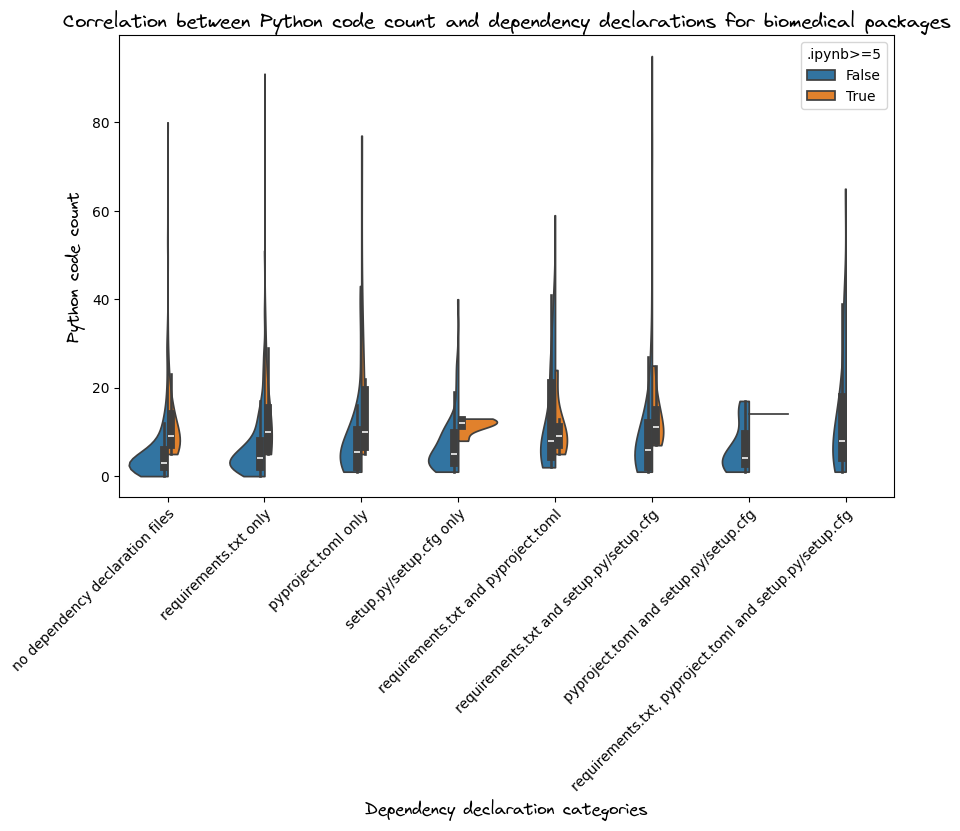

In [177]:
ax = sns.violinplot(y="count", x="deps", hue=".ipynb>=5", data=codedirs_sum_main_biomed[codedirs_sum_main_biomed["count"] < 100], split=True, cut=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Correlation between Python code count and dependency declarations for biomedical packages", fontname='Virgil 3 YOFF', fontsize=14)
plt.xlabel('Dependency declaration categories', fontname='Virgil 3 YOFF', fontsize=12)
plt.ylabel('Python code count', fontname='Virgil 3 YOFF', fontsize=12)
# plt.savefig("correlation_biomed_1.png", dpi=600, bbox_inches="tight")

Text(0, 0.5, 'Python code count')

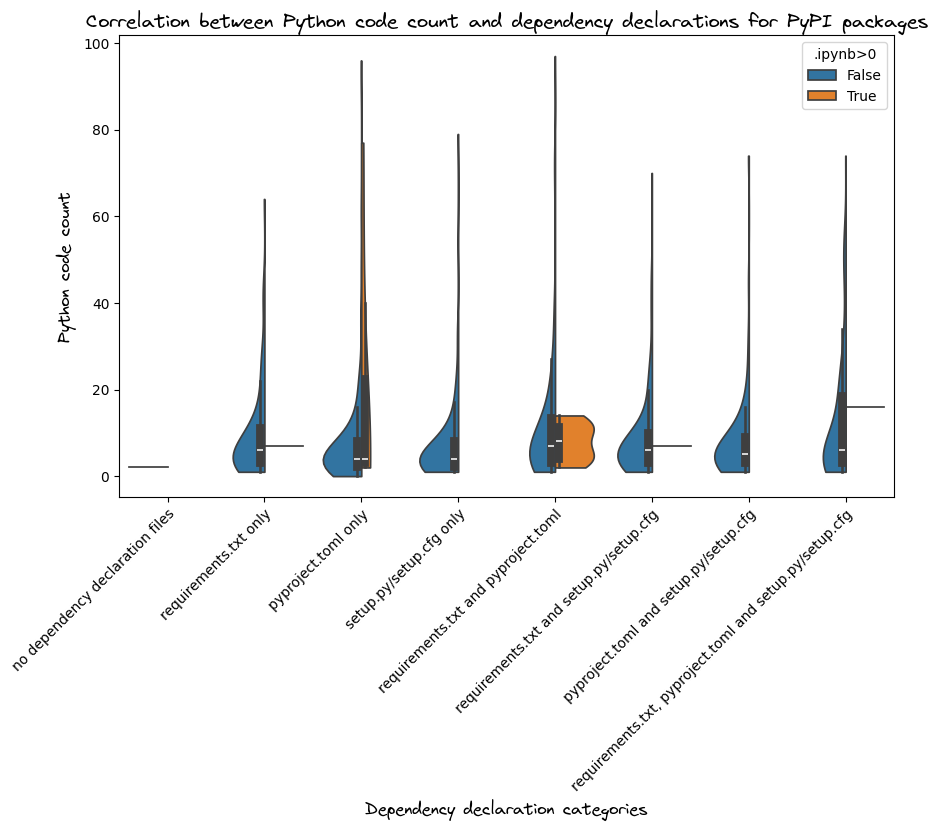

In [172]:
ax = sns.violinplot(y="count", x="deps", hue=".ipynb>0", data=codedirs_sum_main_pypi[codedirs_sum_main_pypi["count"] < 100], split=True, cut=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Correlation between Python code count and dependency declarations for PyPI packages", fontname='Virgil 3 YOFF', fontsize=14)
plt.xlabel('Dependency declaration categories', fontname='Virgil 3 YOFF', fontsize=12)
plt.ylabel('Python code count', fontname='Virgil 3 YOFF', fontsize=12)
# plt.savefig("correlation_pypi_1.png", dpi=600, bbox_inches="tight")


Text(0, 0.5, 'Python code count')

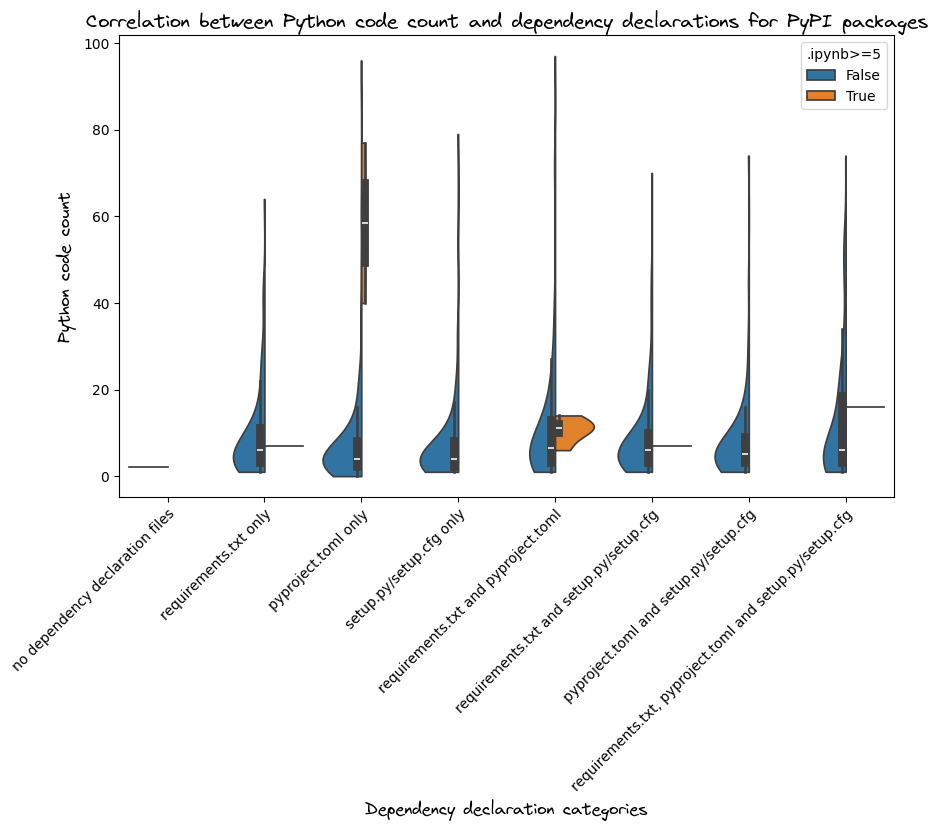

In [175]:
ax = sns.violinplot(y="count", x="deps", hue=".ipynb>=5", data=codedirs_sum_main_pypi[codedirs_sum_main_pypi["count"] < 100], split=True, cut=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("Correlation between Python code count and dependency declarations for PyPI packages", fontname='Virgil 3 YOFF', fontsize=14)
plt.xlabel('Dependency declaration categories', fontname='Virgil 3 YOFF', fontsize=12)
plt.ylabel('Python code count', fontname='Virgil 3 YOFF', fontsize=12)
# plt.savefig("correlation_pypi_2.png", dpi=600, bbox_inches="tight")